In [1]:
import os
import numpy as np
import allel
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gffutils

In [2]:
os.chdir('/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering')
os.getcwd()

'/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering'

In [3]:
# convert phased, filtered, VCF file to zarr file
# already converted to zarr
#allel.vcf_to_zarr('2019melasglobal_finalfiltered_gambiaealigned_phased.vcf.gz', '2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', fields='*', overwrite=True)

In [4]:
callset = zarr.open('2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', mode='r')
#callset.tree(expand=True)

In [5]:
## convert zarr file to genotype array
gt = allel.GenotypeDaskArray(callset['calldata/GT'])
print(gt.shape)

(6767012, 37, 2)


In [6]:
## import metadata
df_samples=pd.read_csv('metadata_melasplusglobal.csv',sep=',',usecols=['sample','country','year','species','island'])
df_samples.head()
df_samples.groupby(by=['country']).count

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fc788176500>>

In [7]:
## VCF is phased so we can convert genotype arrays made earlier to haplotype array

sample_ids = callset['samples'][:]

In [8]:
# Get sample identifiers for Cameroon samples from df_samples
cam_sample_ids = df_samples[df_samples['country'] == 'Cameroon']['sample'].values
# Find indices of these samples in the genotype array
cam_indices = np.array([np.where(sample_ids == id)[0][0] for id in cam_sample_ids if id in sample_ids])
# Verify the indices are within the correct range
print("Max index:", cam_indices.max(), "Sample array size:", len(sample_ids))
# Select genotypes for Cameroon samples using the indices
gt_cam_samples = gt.take(cam_indices, axis=1)

Max index: 36 Sample array size: 37


In [9]:
# Get sample identifiers for Bijagos samples from df_samples
bij_sample_ids = df_samples[df_samples['country'] == 'Guinea-Bissau']['sample'].values
# Find indices of these samples in the genotype array
bij_indices = np.array([np.where(sample_ids == id)[0][0] for id in bij_sample_ids if id in sample_ids])
# Verify the indices are within the correct range
print("Max index:", bij_indices.max(), "Sample array size:", len(sample_ids))
# Select genotypes for Cameroon samples using the indices
gt_bij_samples = gt.take(bij_indices, axis=1)

Max index: 29 Sample array size: 37


In [10]:
h_array_cameroon = gt_cam_samples.to_haplotypes().compute()
h_array_cameroon

h_array_bijagos = gt_bij_samples.to_haplotypes().compute()
h_array_bijagos

<HaplotypeArray shape=(6767012, 60) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 1 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 1 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
pos = callset['variants/POS'][:]
chrom = callset['variants/CHROM'][:]

In [12]:
# xpehh_raw = allel.xpehh(h_sus, h_res, pos, map_pos=None, min_ehh=0.05, include_edges=False, gap_scale=20000, max_gap=20000, is_accessible=None, use_threads=True)
xpehh_raw = allel.xpehh(h_array_bijagos, h_array_cameroon, pos, use_threads=True)
xpehh_raw

array([nan, nan, nan, ..., nan, nan, nan])

In [13]:
xpehh_hit_max = np.nanargmax(xpehh_raw)
xpehh_hit_max

3417076

In [14]:
pos[xpehh_hit_max]

1545186

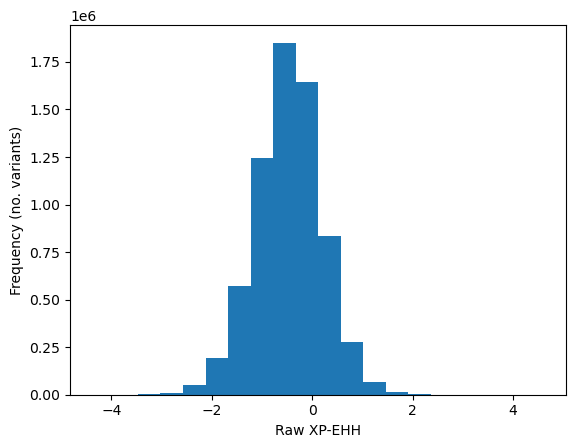

In [15]:
fig, ax = plt.subplots()
ax.hist(xpehh_raw[~np.isnan(xpehh_raw)], bins=20)
ax.set_xlabel('Raw XP-EHH')
ax.set_ylabel('Frequency (no. variants)');

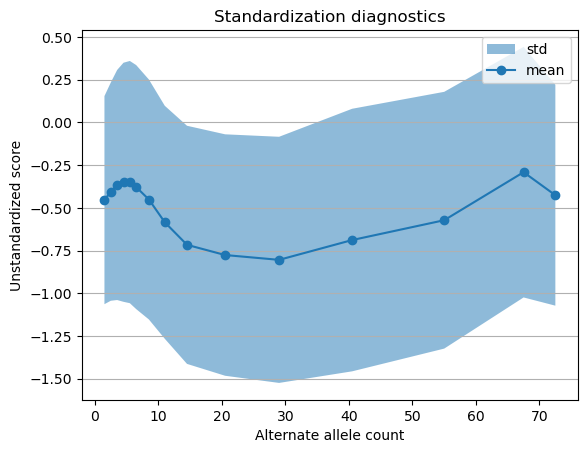

In [16]:
allele_counts_array = gt.count_alleles(max_allele=3).compute()
xpehh_std = allel.standardize_by_allele_count(xpehh_raw, allele_counts_array[:, 1])

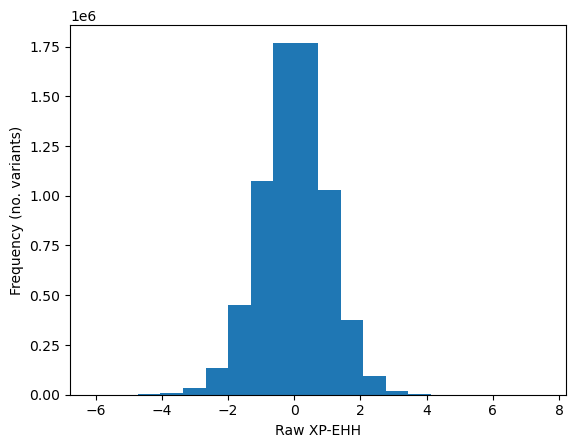

In [17]:
fig, ax = plt.subplots()
ax.hist(xpehh_std[0][~np.isnan(xpehh_std[0])], bins=20)
ax.set_xlabel('Raw XP-EHH')
ax.set_ylabel('Frequency (no. variants)');

In [18]:
# define chromosome lengths and colours 
chromosome_lengths = {
    '2L': 49364325,
    '2R': 61545105,
    '3L': 41963435,
    '3R': 53200684,
    'anop_mito': 15363,
    'anop_X': 24393108
}

# Calculate cumulative offsets for each chromosome
cumulative_lengths = {}
cumulative_length = 0
for chrom, length in chromosome_lengths.items():
    cumulative_lengths[chrom] = cumulative_length
    cumulative_length += length

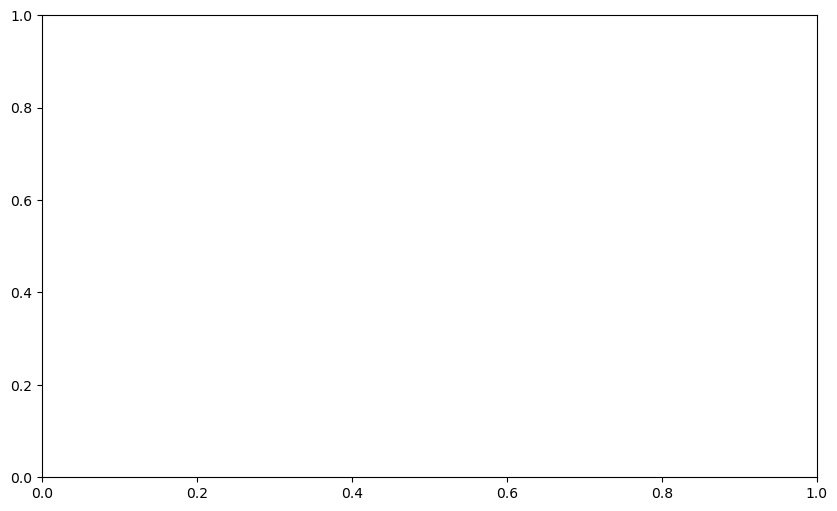

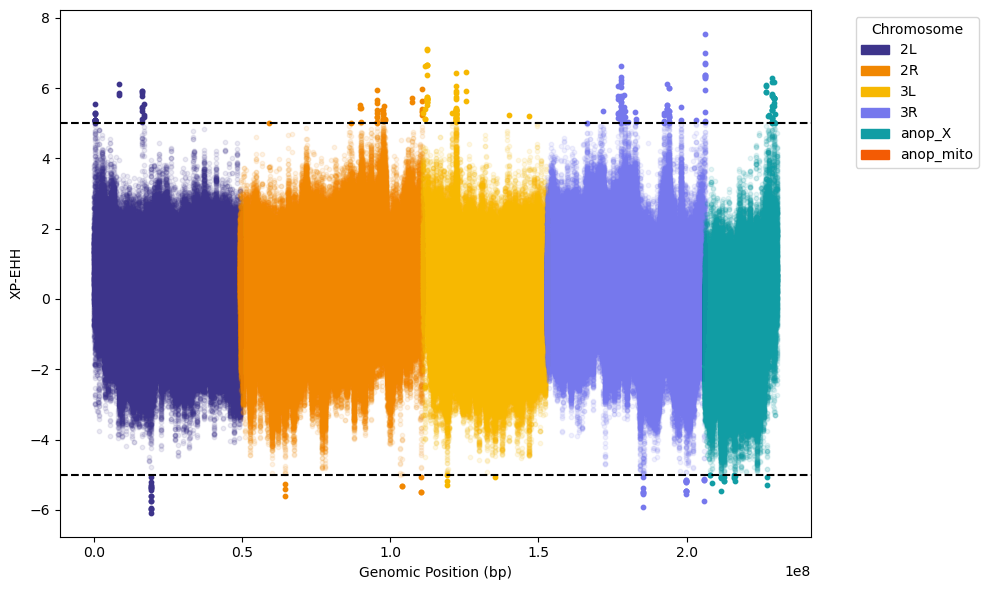

In [19]:
# Set threshold
bijagos_threshold = 5
cameroon_threshold = -5

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure that pos, chrom, and xpehh_std are all numpy arrays to support advanced indexing
pos = np.array(callset['variants/POS'][:])
chrom = np.array(callset['variants/CHROM'][:])
xpehh_standardised_values = np.array(xpehh_std[0])

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each chromosome (for illustration)
chromosome_colours = {
    '2L': '#3d348b', '2R': '#f18701', '3L': '#f7b801', '3R': '#7678ed', 'anop_mito': '#f35b04', 'anop_X': '#119DA4'
}

# Set threshold
bijagos_threshold = 5
cameroon_threshold = -5

# Create a list to hold the legend patches
legend_patches = []

# Filtered chromosomes list, assuming cumulative_lengths are defined for these
filtered_chroms = ['2L', '2R', '3L', '3R', 'anop_X', 'anop_mito']

# Iterate through each chromosome to plot its variants
for unique_chrom in filtered_chroms:
    chrom_mask = chrom == unique_chrom
    
    chrom_positions = pos[chrom_mask]
    chrom_xpehh_values = xpehh_standardised_values[chrom_mask]
    
    non_nan_mask = ~np.isnan(chrom_xpehh_values)
    chrom_positions_no_nan = chrom_positions[non_nan_mask]
    chrom_xpehh_values_no_nan = chrom_xpehh_values[non_nan_mask]
    
    adjusted_positions = chrom_positions_no_nan + cumulative_lengths.get(unique_chrom, 0)

    # Conditions for plotting
    solid_mask = (chrom_xpehh_values_no_nan >= bijagos_threshold) | (chrom_xpehh_values_no_nan <= cameroon_threshold)
    faded_mask = ~solid_mask
    
    # Plot solid points for values above 5 or below -5
    ax.scatter(adjusted_positions[solid_mask], 
               chrom_xpehh_values_no_nan[solid_mask], 
               color=chromosome_colours[unique_chrom], alpha=1.0, s=10)
    
    # Plot faded points for other values
    ax.scatter(adjusted_positions[faded_mask], 
               chrom_xpehh_values_no_nan[faded_mask], 
               color=chromosome_colours[unique_chrom], alpha=0.1, s=10)
    
    # Add patch for the legend
    patch = mpatches.Patch(color=chromosome_colours[unique_chrom], label=unique_chrom)
    legend_patches.append(patch)

# Add significance threshold lines and legend
ax.axhline(y=bijagos_threshold, color='black', linestyle='--', label='Bijagos Threshold')
ax.axhline(y=cameroon_threshold, color='black', linestyle='--', label='Cameroon Threshold')
ax.legend(handles=legend_patches, title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set labels
ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('XP-EHH')
plt.tight_layout()
plt.savefig('xpehh_plot_600ppi.png', dpi=600)  # Save at 600 PPI

In [20]:
bijagos_threshold_mask = xpehh_standardised_values >= bijagos_threshold
cameroon_threshold_mask = xpehh_standardised_values <= cameroon_threshold

In [21]:
bij_significant_chrom = chrom[bijagos_threshold_mask]
bij_significant_pos = pos[bijagos_threshold_mask]
bij_significant_xpehh = xpehh_standardised_values[bijagos_threshold_mask]

cam_significant_chrom = chrom[cameroon_threshold_mask]
cam_significant_pos = pos[cameroon_threshold_mask]
cam_significant_xpehh = xpehh_standardised_values[cameroon_threshold_mask]

In [22]:
bij_significant_xpehh_data = np.column_stack((bij_significant_chrom, bij_significant_pos, bij_significant_xpehh))
cam_significant_xpehh_data = np.column_stack((cam_significant_chrom, cam_significant_pos, cam_significant_xpehh))

In [23]:
df_significant_bij_xpehh = pd.DataFrame(bij_significant_xpehh_data, columns=['Chromosome', 'Position', 'XPEHH'])
df_significant_cam_xpehh = pd.DataFrame(cam_significant_xpehh_data, columns = ['Chromosome', 'Position', 'XPEHH'])

In [24]:
df_significant_bij_xpehh.to_csv(f'df_significant_bij_xpehh_bijagos_threshold_{bijagos_threshold}.csv', index=False)
df_significant_cam_xpehh.to_csv(f'df_significant_cam_xpehh_cameroon_threshold_{cameroon_threshold}.csv', index=False)

In [25]:
print("Using GFF file to bring in annotations for these positions")

## Annotate the Bijagos XPEHH file
# Parameters
input_file_name = f"df_significant_bij_xpehh_bijagos_threshold_{bijagos_threshold}.csv"
output_file_name = f"df_significant_bij_xpehh_bijagos_threshold_{bijagos_threshold}_annotated.csv"
gff_file = '/mnt/storage11/sophie/reference_genomes/A_gam_P4_ensembl/Anopheles_gambiae.AgamP4.56.chr.gff3'

# Function to find and format the GFF line(s) that overlap a given position
def find_overlapping_gff_lines(chromosome, position, gff_file):
    overlapping_lines = []
    with open(gff_file, 'r') as gff:
        for line in gff:
            if line.startswith('#') or line.strip() == "":
                continue  # Skip header and empty lines
            parts = line.split('\t')
            if parts[0] == chromosome and int(parts[3]) <= position <= int(parts[4]):
                formatted_line = ",".join(parts).strip()
                overlapping_lines.append(formatted_line)
    return overlapping_lines

# Open the output file to write the annotated positions
with open(output_file_name, "w") as outfile:
    # Write the header line
    outfile.write("Chromosome,Position,XPEHH,Gff_Annotation\n")

    # Open the file containing significant iHS positions to read
    with open(input_file_name, "r") as infile:
        next(infile) #skip header line
        for line in infile:
            parts = line.strip().split(",")
            chromosome, position, XPEHH = parts[0], int(parts[1]), parts[2]
            
            # Find overlapping GFF lines for the position
            overlapping_gff_lines = find_overlapping_gff_lines(chromosome, position, gff_file)
            
            # Join all overlapping GFF lines into a single string
            gff_annotation = "; ".join(overlapping_gff_lines)
            
            # Write to the output file
            outfile.write(f"{chromosome},{position},{XPEHH},{gff_annotation}\n")

print(f"XP-EHH significant values identified and GFF annotations written here: {output_file_name}")

Using GFF file to bring in annotations for these positions
XP-EHH significant values identified and GFF annotations written here: df_significant_bij_xpehh_bijagos_threshold_5_annotated.csv


In [26]:
## Annotate the Cameroon XPEHH file
# Parameters
input_file_name = f"df_significant_cam_xpehh_cameroon_threshold_{cameroon_threshold}.csv"
output_file_name = f"df_significant_cam_xpehh_cameroon_threshold_{cameroon_threshold}_annotated.csv"
gff_file = '/mnt/storage11/sophie/reference_genomes/A_gam_P4_ensembl/Anopheles_gambiae.AgamP4.56.chr.gff3'

# Function to find and format the GFF line(s) that overlap a given position
def find_overlapping_gff_lines(chromosome, position, gff_file):
    overlapping_lines = []
    with open(gff_file, 'r') as gff:
        for line in gff:
            if line.startswith('#') or line.strip() == "":
                continue  # Skip header and empty lines
            parts = line.split('\t')
            if parts[0] == chromosome and int(parts[3]) <= position <= int(parts[4]):
                formatted_line = ",".join(parts).strip()
                overlapping_lines.append(formatted_line)
    return overlapping_lines

# Open the output file to write the annotated positions
with open(output_file_name, "w") as outfile:
    # Write the header line
    outfile.write("Chromosome,Position,XPEHH,Gff_Annotation\n")

    # Open the file containing significant iHS positions to read
    with open(input_file_name, "r") as infile:
        next(infile) #skip header line
        for line in infile:
            parts = line.strip().split(",")
            chromosome, position, XPEHH = parts[0], int(parts[1]), parts[2]
            
            # Find overlapping GFF lines for the position
            overlapping_gff_lines = find_overlapping_gff_lines(chromosome, position, gff_file)
            
            # Join all overlapping GFF lines into a single string
            gff_annotation = "; ".join(overlapping_gff_lines)
            
            # Write to the output file
            outfile.write(f"{chromosome},{position},{XPEHH},{gff_annotation}\n")

print(f"XP-EHH significant values identified and GFF annotations written here: {output_file_name}")

XP-EHH significant values identified and GFF annotations written here: df_significant_cam_xpehh_cameroon_threshold_-5_annotated.csv
